In [10]:
# To have reproducible results and compare them
nr_seed = 2024

import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.random.set_seed(nr_seed)

In [14]:
# import libraries
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from keras.applications.resnet50 import ResNet50
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Dataset 1 : EyePACS 

In [17]:
import sklearn.model_selection

#import the first dataset ()
df1 = pd.read_csv('/kaggle/input/diabetic-retinopathy-resized/trainLabels.csv')
# img_path = '/kaggle/input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/'
img_path = '/kaggle/input/diabetic-retinopathy-resized/resized_train/resized_train/'
df1['img_path'] = img_path + df1.image + '.jpeg'

df1 = df1.drop(columns=['image'])

# Rename a single column
df1.rename(columns={"level": "grade"}, inplace=True)

# Reorder the columns to make the second column the first
cols = df1.columns.tolist()  # Get a list of all column names
cols = [cols[1]] + [cols[0]] + cols[2:]  # Move the second column to the first position

# Apply the new order to the DataFrame
df1 = df1[cols]
df1

,img_path,grade
0,/kaggle/input/diabetic-retinopathy-resized/res...,0
1,/kaggle/input/diabetic-retinopathy-resized/res...,0
2,/kaggle/input/diabetic-retinopathy-resized/res...,0
3,/kaggle/input/diabetic-retinopathy-resized/res...,0
4,/kaggle/input/diabetic-retinopathy-resized/res...,1
...,...,...
35121,/kaggle/input/diabetic-retinopathy-resized/res...,0
35122,/kaggle/input/diabetic-retinopathy-resized/res...,0
35123,/kaggle/input/diabetic-retinopathy-resized/res...,0
35124,/kaggle/input/diabetic-retinopathy-resized/res...,0


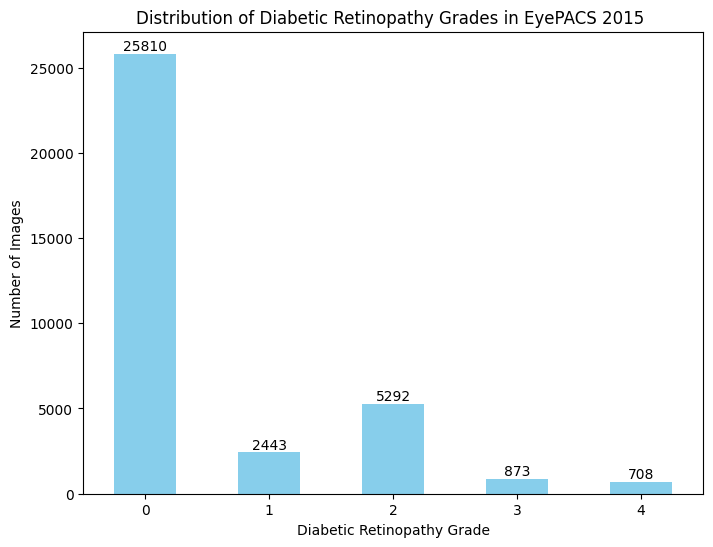

   Diagnosis Grade  Frequency
0                0      25810
1                1       2443
2                2       5292
3                3        873
4                4        708


In [26]:
df1_grade_distribution = df1['grade'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
ax = class_distribution_df1.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Distribution of Diabetic Retinopathy Grades in EyePACS 2015 ')
plt.xlabel('Diabetic Retinopathy Grade')
plt.ylabel('Number of Images')

# Annotate the bars with the count of samples
for i, count in enumerate(df1_grade_distribution.values):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
# Rotate x-axis labels to vertical using plt.xticks
plt.xticks(rotation=360)

# Show the plot
plt.show()

# Create a table to show grade distribution in EyePACS 2015
df1_grade_distribution_table = pd.DataFrame({'Diagnosis Grade': df1_grade_distribution.index, 'Frequency': df1_grade_distribution.values})
print(df1_grade_distribution_table)

# Dataset 2 : APTOS 2019

In [22]:
df2 = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
df2["img_path"] = df2["id_code"].map(lambda x:os.path.join("../input/aptos2019-blindness-detection/train_images",x+".png"))
# Rename multiple columns
df2.rename(columns={"id_code": "image", "diagnosis": "grade"}, inplace=True)

df2 = df2.drop(columns=['image'])

# Reorder the columns to make the second column the first
cols = df2.columns.tolist()  # Get a list of all column names
cols = [cols[1]] + [cols[0]] + cols[2:]  # Move the second column to the first position

# Apply the new order to the DataFrame
df2 = df2[cols]
df2

# Display the DataFrame with renamed columns
df2

,img_path,grade
0,../input/aptos2019-blindness-detection/train_i...,2
1,../input/aptos2019-blindness-detection/train_i...,4
2,../input/aptos2019-blindness-detection/train_i...,1
3,../input/aptos2019-blindness-detection/train_i...,0
4,../input/aptos2019-blindness-detection/train_i...,0
...,...,...
3657,../input/aptos2019-blindness-detection/train_i...,2
3658,../input/aptos2019-blindness-detection/train_i...,0
3659,../input/aptos2019-blindness-detection/train_i...,2
3660,../input/aptos2019-blindness-detection/train_i...,0


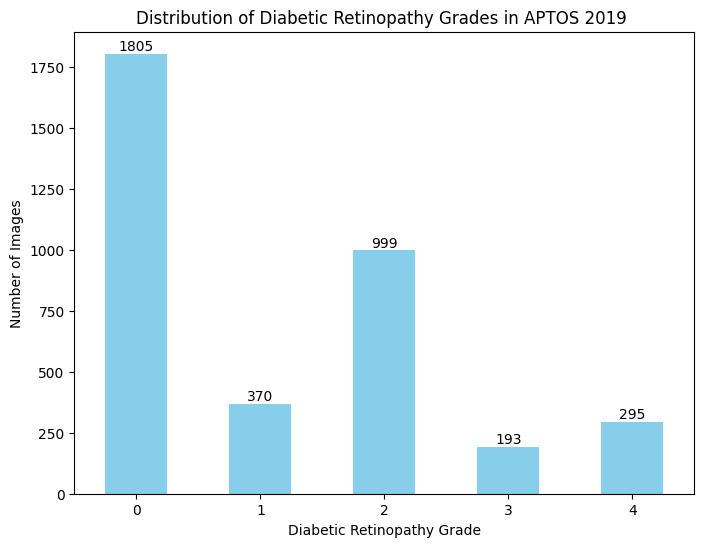

   Diagnosis Grade  Frequency
0                0       1805
1                1        370
2                2        999
3                3        193
4                4        295


In [25]:
df2_grade_distribution = df2['grade'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
ax = df2_grade_distribution.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Distribution of Diabetic Retinopathy Grades in APTOS 2019 ')
plt.xlabel('Diabetic Retinopathy Grade')
plt.ylabel('Number of Images')

# Annotate the bars with the count of samples
for i, count in enumerate(df2_grade_distribution.values):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
# Rotate x-axis labels to vertical using plt.xticks
plt.xticks(rotation=360)

# Show the plot
plt.show()

# Create a table to show grade distribution in EyePACS 2015
df2_grade_distribution_table = pd.DataFrame({'Diagnosis Grade': df2_grade_distribution.index, 'Frequency': df2_grade_distribution.values})
print(df2_grade_distribution_table)

# Dataset 3: Messidor-2

In [31]:
df3 = pd.read_csv('../input/messidor2preprocess/messidor_data.csv')
# Drop the columns adjudicated_dme and adjudicated_gradable
df3.drop(['adjudicated_dme', 'adjudicated_gradable'], axis=1, inplace=True)
df3["img_path"] = df3["id_code"].map(lambda x:os.path.join("../input/messidor2preprocess/messidor-2/messidor-2/preprocess",x+".png"))

df3 = df3.drop(columns=['id_code'])
df3.rename(columns={"diagnosis": "grade"}, inplace=True)

# Reorder the columns to make the second column the first
cols = df3.columns.tolist()  # Get a list of all column names
cols = [cols[1]] + [cols[0]] + cols[2:]  # Move the second column to the first position

# Apply the new order to the DataFrame
df3 = df3[cols]

# Display the DataFrame with renamed columns
df3

,img_path,grade
0,../input/messidor2preprocess/messidor-2/messid...,0
1,../input/messidor2preprocess/messidor-2/messid...,1
2,../input/messidor2preprocess/messidor-2/messid...,1
3,../input/messidor2preprocess/messidor-2/messid...,2
4,../input/messidor2preprocess/messidor-2/messid...,0
...,...,...
1739,../input/messidor2preprocess/messidor-2/messid...,0
1740,../input/messidor2preprocess/messidor-2/messid...,1
1741,../input/messidor2preprocess/messidor-2/messid...,2
1742,../input/messidor2preprocess/messidor-2/messid...,0


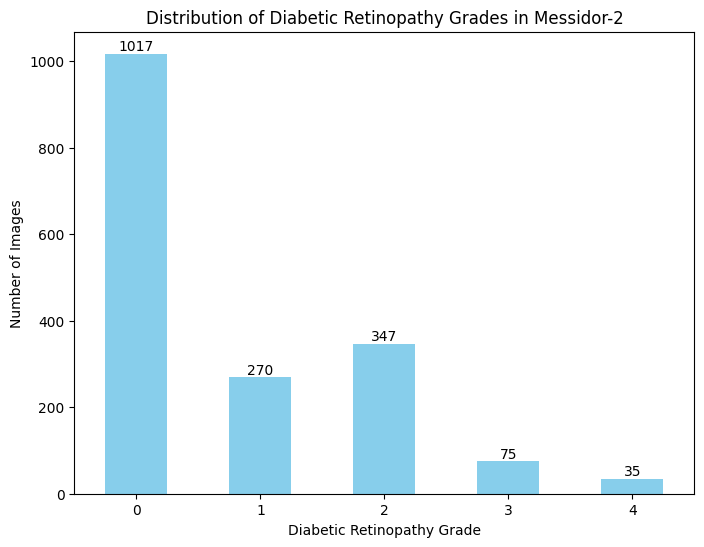

   Diagnosis Grade  Frequency
0                0       1017
1                1        270
2                2        347
3                3         75
4                4         35


In [38]:
df3_grade_distribution = df3['grade'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
ax = df3_grade_distribution.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Distribution of Diabetic Retinopathy Grades in Messidor-2')
plt.xlabel('Diabetic Retinopathy Grade')
plt.ylabel('Number of Images')

# Annotate the bars with the count of samples
for i, count in enumerate(df3_grade_distribution.values):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
# Rotate x-axis labels to vertical using plt.xticks
plt.xticks(rotation=360)

# Show the plot
plt.show()

# Create a table to show grade distribution in EyePACS 2015
df3_grade_distribution_table = pd.DataFrame({'Diagnosis Grade': df3_grade_distribution.index, 'Frequency': df3_grade_distribution.values})
print(df3_grade_distribution_table)

# Combined 3 dataset

In [35]:
# Combine the DataFrames (assuming row-wise concatenation as before)
combined_df = pd.concat([df1, df2, df3], axis=0)

combined_df

,img_path,grade
0,/kaggle/input/diabetic-retinopathy-resized/res...,0
1,/kaggle/input/diabetic-retinopathy-resized/res...,0
2,/kaggle/input/diabetic-retinopathy-resized/res...,0
3,/kaggle/input/diabetic-retinopathy-resized/res...,0
4,/kaggle/input/diabetic-retinopathy-resized/res...,1
...,...,...
1739,../input/messidor2preprocess/messidor-2/messid...,0
1740,../input/messidor2preprocess/messidor-2/messid...,1
1741,../input/messidor2preprocess/messidor-2/messid...,2
1742,../input/messidor2preprocess/messidor-2/messid...,0


         df1   df2   df3  combined
grade                             
0      25810  1805  1017     28632
1       2443   370   270      3083
2       5292   999   347      6638
3        873   193    75      1141
4        708   295    35      1038


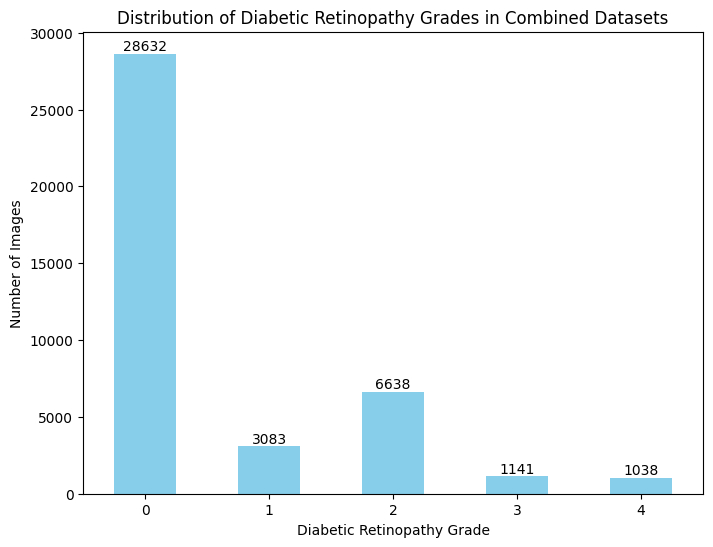

   Class  Frequency
0      0      28632
1      1       3083
2      2       6638
3      3       1141
4      4       1038


In [41]:
import pandas as pd
import matplotlib.pyplot as plt

combined_grade_distribution = combined_df['grade'].value_counts().sort_index()

# Create a DataFrame with class distribution for all datasets
distribution_table = pd.DataFrame({
    'df1': df1_grade_distribution,
    'df2': df2_grade_distribution,
    'df3': df3_grade_distribution,
    'combined': combined_grade_distribution
})

# Fill missing values with 0 if a class does not appear in a dataset
distribution_table = distribution_table.fillna(0).astype(int)

# Display the class distribution table
print(distribution_table)

# Plot the bar chart for the combined dataset
plt.figure(figsize=(8, 6))
ax = combined_grade_distribution.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Distribution of Diabetic Retinopathy Grades in Combined Datasets')
plt.xlabel('Diabetic Retinopathy Grade')
plt.ylabel('Number of Images')

# Annotate the bars with the count of samples
for i, count in enumerate(combined_grade_distribution.values):
    ax.text(i, count, str(count), ha='center', va='bottom')

# Rotate x-axis labels to vertical using plt.xticks
plt.xticks(rotation=360)

# Show the plot
plt.show()

# Create a class distribution table for the combined dataset
combined_grade_distribution_table = pd.DataFrame({
    'Class': combined_grade_distribution.index,
    'Frequency': combined_grade_distribution.values
})

print(combined_grade_distribution_table)

## Print sample image 